<a href="https://colab.research.google.com/github/Savvy-Slowley/Dog-Tag-OCR/blob/main/Dog_Tag_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyTorch (Colab has CUDA preinstalled)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121

# Install EasyOCR
!pip install easyocr

# Install PaddleOCR
!pip install paddlepaddle paddleocr

# Install OpenCV and dependencies
!pip install opencv-python-headless numpy matplotlib pandas

#Install a known font (e.g., DejaVu Sans) in your environment.
!apt-get update
!apt-get install -y fonts-dejavu-core

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,911 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,526 kB]
Fetc

In [ ]:
import os  # File handling (reading/writing files, managing paths)
import cv2  # Image processing (reading, writing, and manipulating images)
import easyocr  # Optical Character Recognition (OCR) to extract text from images
import numpy as np  # Numerical operations, image processing, and array handling
import pandas as pd  # Data manipulation and storing OCR results
import matplotlib.pyplot as plt  # Visualization (displaying images and results)
from PIL import Image, ImageDraw, ImageFont  # Image handling, drawing, and adding text
from paddleocr import PaddleOCR, draw_ocr  # OCR model and visualization utilities

# OCR Pipeline
### This demonstrates text extraction from images using PaddleOCR and EasyOCR.

## **1. Setup and Configuration**
### Define Constants

In [ ]:
# Define Constants
IMG_PATH = "./dogtag1.jpg"
IMG_PATH2 = "/content/Dogtag2.png"
IMG_PATH3 = "/content/3_clahe.png"
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"

## **2. Utility Functions**
### **Check Font Availability**

In [ ]:
# Check if the font exists
def check_font(font_path):
    if not os.path.exists(font_path):
        raise FileNotFoundError(f"Font not found at: {font_path}. Install a TTF font or update FONT_PATH.")

### **Load Image in RGB Format**

In [ ]:
# Load image in RGB format
def load_image(img_path):
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## **3. OCR Models**
### **Run PaddleOCR**

In [ ]:
# Run PaddleOCR
def run_paddleocr(img_path):
    ocr = PaddleOCR(use_angle_cls=True, lang='en')
    result = ocr.ocr(img_path, cls=True)
    boxes = [res[0] for res in result[0]]
    texts = [res[1][0] for res in result[0]]
    scores = [res[1][1] for res in result[0]]
    return boxes, texts, scores

### **Run EasyOCR**

In [ ]:
# Run EasyOCR
def run_easyocr(img_path):
    reader = easyocr.Reader(['en'])
    result = reader.readtext(img_path)
    boxes = [res[0] for res in result]
    texts = [res[1] for res in result]
    scores = [res[2] for res in result]
    return boxes, texts, scores

## **4. Visualization and Annotation**
### **Draw Bounding Boxes**

In [ ]:
# Function to draw bounding boxes using cv2.polylines()
def draw_boxes(img, boxes):
    img_copy = img.copy()
    for bbox in boxes:
        pts = np.array(bbox, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(img_copy, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    return img_copy

### **Add Text Annotations**

In [ ]:
# Extend the image and add text annotations
def add_text_annotations(img, texts, scores, font_path, margin=300, font_size=18):
    height, width, _ = img.shape
    extended_img = np.ones((height, width + margin, 3), dtype=np.uint8) * 255
    extended_img[:height, :width] = img

    pil_img = Image.fromarray(extended_img)
    draw = ImageDraw.Draw(pil_img)

    # Load font
    try:
        font = ImageFont.truetype(font_path, font_size)
    except OSError:
        font = ImageFont.load_default()

    x_offset, y_offset, line_spacing = width + 10, 40, 30
    for text, score in zip(texts, scores):
        label = f"{text} ({score:.4f})"
        draw.text((x_offset, y_offset), label, font=font, fill=(0, 0, 0))
        y_offset += line_spacing

    return np.array(pil_img)

### **Visualize Results**

In [ ]:
# Visualize results
def visualize_results(paddle_annotated, easy_annotated):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(paddle_annotated)
    axes[0].set_title("PaddleOCR Results", fontsize=24)
    axes[0].axis("off")

    axes[1].imshow(easy_annotated)
    axes[1].set_title("EasyOCR Results", fontsize=24)
    axes[1].axis("off")

    plt.show()

In [ ]:
def parse_and_export_dogtag(paddle_texts, output_excel):
    """
    Parse recognized text from PaddleOCR and export to Excel.
    Adjust the parsing logic according to your actual dog tag format.
    """
    # Basic example:
    last_name = paddle_texts[0] if len(paddle_texts) > 0 else ''
    first_name = ''
    middle_initial = ''
    suffix = ''

    if len(paddle_texts) > 1:
        name_parts = paddle_texts[1].split()
        if len(name_parts) >= 1:
            first_name = name_parts[0]
        if len(name_parts) >= 2:
            middle_initial = name_parts[1]
        if len(name_parts) >= 3:
            suffix = name_parts[2]

    service_number = paddle_texts[2] if len(paddle_texts) > 2 else ''
    blood_type = paddle_texts[3] if len(paddle_texts) > 3 else ''
    religion = paddle_texts[4] if len(paddle_texts) > 4 else ''

    dogtag_data = {
        "First Name": first_name,
        "Middle Initial": middle_initial,
        "Last Name": last_name,
        "Suffix": suffix,
        "Service Number": service_number,
        "Blood Type": blood_type,
        "Religion": religion
    }

    df = pd.DataFrame([dogtag_data])
    out_dir = os.path.dirname(output_excel)
    if out_dir and not os.path.exists(out_dir):
        os.makedirs(out_dir, exist_ok=True)

    df.to_excel(output_excel, index=False)
    print(f"\nDog tag data saved to: {output_excel}")
    print(df)

## **5. Execution With PARSE**

In [ ]:
def maindf(img_path, font_path):
    check_font(font_path)
    img = load_image(img_path)

    print("Running PaddleOCR...")
    paddle_boxes, paddle_texts, paddle_scores = run_paddleocr(img_path)
    paddle_annotated = draw_boxes(img, paddle_boxes)
    paddle_annotated = add_text_annotations(paddle_annotated, paddle_texts, paddle_scores, font_path)

    print("Running EasyOCR...")
    easy_boxes, easy_texts, easy_scores = run_easyocr(img_path)
    easy_annotated = draw_boxes(img, easy_boxes)
    easy_annotated = add_text_annotations(easy_annotated, easy_texts, easy_scores, font_path)

    visualize_results(paddle_annotated, easy_annotated)

    print("\nPaddleOCR Results:")
    for txt, sc in zip(paddle_texts, paddle_scores):
        print(f"  {txt} (confidence={sc:.4f})")

    print("\nEasyOCR Results:")
    for txt, sc in zip(easy_texts, easy_scores):
        print(f"  {txt} (confidence={sc:.4f})")

    # >>>> CALL THE NEW PARSE FUNCTION HERE <<<<
    parse_and_export_dogtag(paddle_texts, "dogtag_output.xlsx")

## **Execution Without PARSE**

In [ ]:
# Main function
def main(img_path, font_path):
    check_font(font_path)
    img = load_image(img_path)

    print("Running PaddleOCR...")
    paddle_boxes, paddle_texts, paddle_scores = run_paddleocr(img_path)
    paddle_annotated = draw_boxes(img, paddle_boxes)
    paddle_annotated = add_text_annotations(paddle_annotated, paddle_texts, paddle_scores, font_path)

    print("Running EasyOCR...")
    easy_boxes, easy_texts, easy_scores = run_easyocr(img_path)
    easy_annotated = draw_boxes(img, easy_boxes)
    easy_annotated = add_text_annotations(easy_annotated, easy_texts, easy_scores, font_path)

    visualize_results(paddle_annotated, easy_annotated)

    print("\nPaddleOCR Results:")
    for txt, sc in zip(paddle_texts, paddle_scores):
        print(f"  {txt} (confidence={sc:.4f})")

    print("\nEasyOCR Results:")
    for txt, sc in zip(easy_texts, easy_scores):
        print(f"  {txt} (confidence={sc:.4f})")

Running PaddleOCR...
[2025/02/13 17:12:18] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

Running EasyOCR...


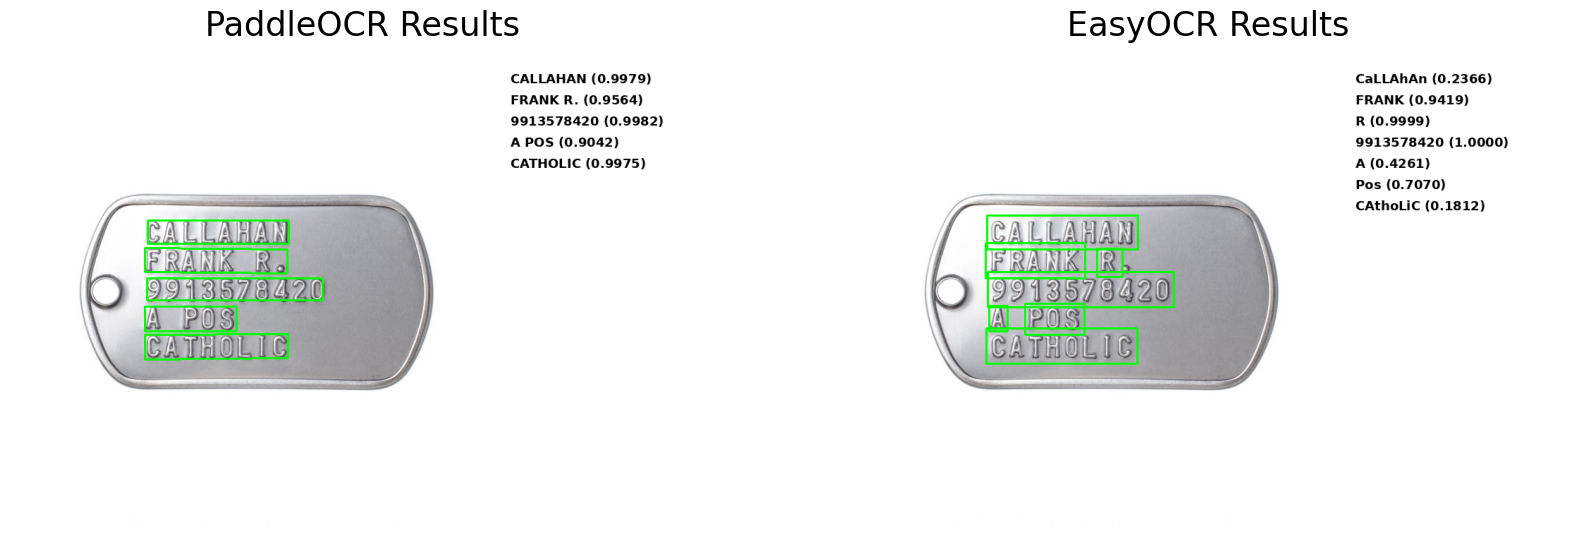


PaddleOCR Results:
  CALLAHAN (confidence=0.9979)
  FRANK R. (confidence=0.9564)
  9913578420 (confidence=0.9982)
  A POS (confidence=0.9042)
  CATHOLIC (confidence=0.9975)

EasyOCR Results:
  CaLLAhAn (confidence=0.2366)
  FRANK (confidence=0.9419)
  R (confidence=0.9999)
  9913578420 (confidence=1.0000)
  A (confidence=0.4261)
  Pos (confidence=0.7070)
  CAthoLiC (confidence=0.1812)

Dog tag data saved to: dogtag_output.xlsx
  First Name Middle Initial Last Name Suffix Service Number Blood Type  \
0      FRANK             R.  CALLAHAN            9913578420      A POS   

   Religion  
0  CATHOLIC  


In [ ]:
maindf(IMG_PATH, FONT_PATH)

# Run on New Image

Running PaddleOCR...
[2025/02/13 17:18:24] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

Running EasyOCR...


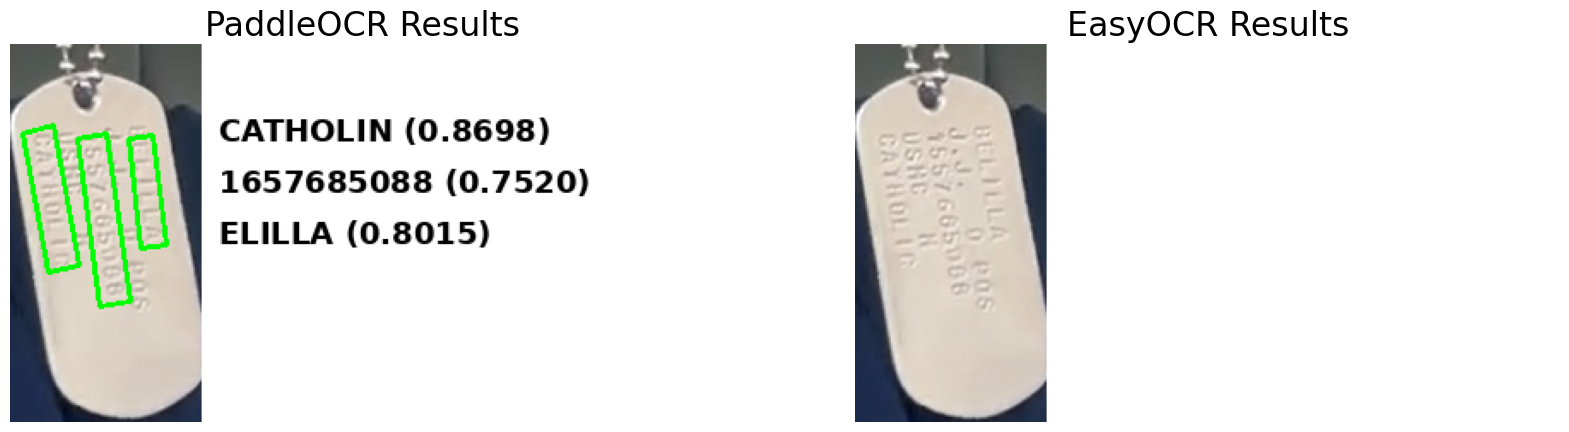


PaddleOCR Results:
  CATHOLIN (confidence=0.8698)
  1657685088 (confidence=0.7520)
  ELILLA (confidence=0.8015)

EasyOCR Results:


In [ ]:
main(IMG_PATH2, FONT_PATH)

## Binarizing (separating foreground text from background) and Cleaning
### 1. Load the image

In [ ]:
image = cv2.imread(IMG_PATH2)

if image is None:
    raise FileNotFoundError(f"Could not load image from {IMG_PATH2}")

### 2. Convert to Grayscale

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### 3. Increase Contrast using CLAHE

In [ ]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
contrast_enhanced = clahe.apply(gray)

### Apply Gaussian Blur to reduce noise

In [ ]:
blurred = cv2.GaussianBlur(contrast_enhanced, (3, 3), 0)

### 5. Use Adaptive Thresholding to binarize the image

In [ ]:
binary = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11,
    2
)

### 6: Apply Morphological Transformations

In [ ]:
kernel = np.ones((2, 2), np.uint8)
processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

### SAVE INTERMEDIATE IMAGES

In [ ]:
cv2.imwrite("1_original.png", image)            # Original (color)
cv2.imwrite("2_grayscale.png", gray)            # Grayscale
cv2.imwrite("3_clahe.png", contrast_enhanced)   # CLAHE result
cv2.imwrite("4_blurred.png", blurred)           # Blurred
cv2.imwrite("5_thresholded.png", binary)        # Adaptive Threshold
cv2.imwrite("6_morph_close.png", processed)     # Morphological transformation

### **Visualize Results**

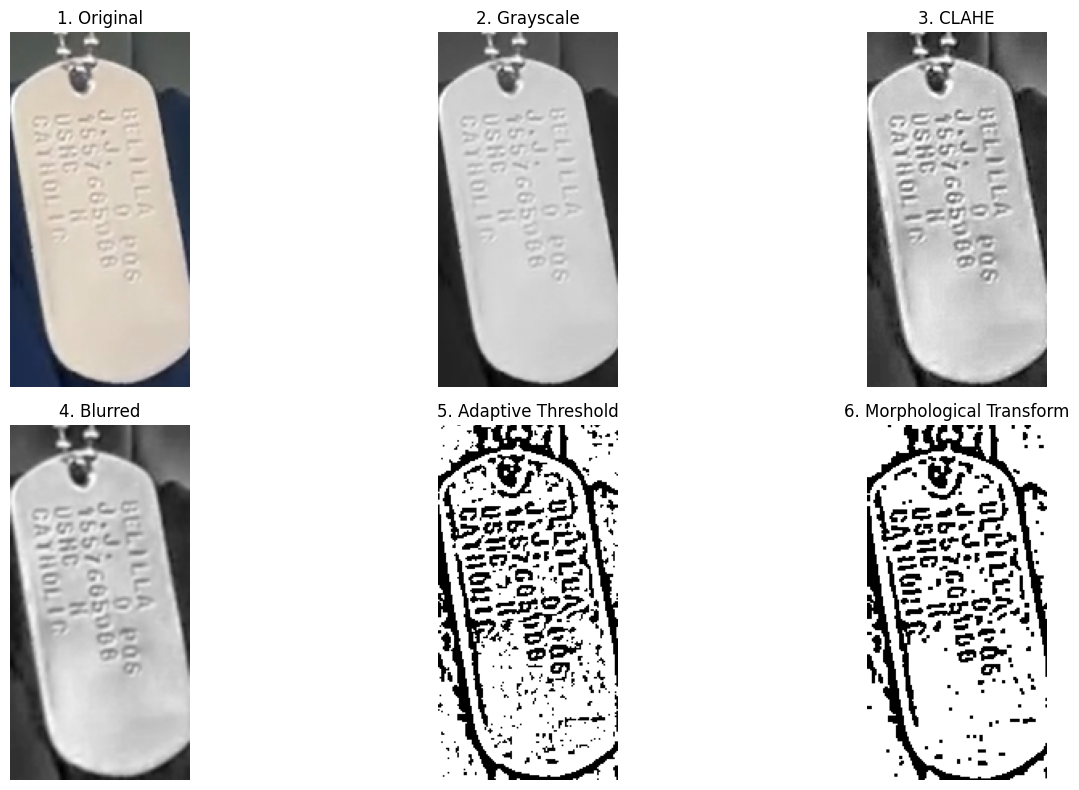

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original image (convert BGR to RGB for matplotlib)
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("1. Original")
axes[0, 0].axis("off")

# Grayscale
axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title("2. Grayscale")
axes[0, 1].axis("off")

# CLAHE (Contrast Enhanced)
axes[0, 2].imshow(contrast_enhanced, cmap='gray')
axes[0, 2].set_title("3. CLAHE")
axes[0, 2].axis("off")

# Blurred
axes[1, 0].imshow(blurred, cmap='gray')
axes[1, 0].set_title("4. Blurred")
axes[1, 0].axis("off")

# Adaptive Threshold
axes[1, 1].imshow(binary, cmap='gray')
axes[1, 1].set_title("5. Adaptive Threshold")
axes[1, 1].axis("off")

# Morphological Transform
axes[1, 2].imshow(processed, cmap='gray')
axes[1, 2].set_title("6. Morphological Transform")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

### Performing OCR On CLAHE

Running PaddleOCR...
[2025/02/13 18:09:45] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

Running EasyOCR...


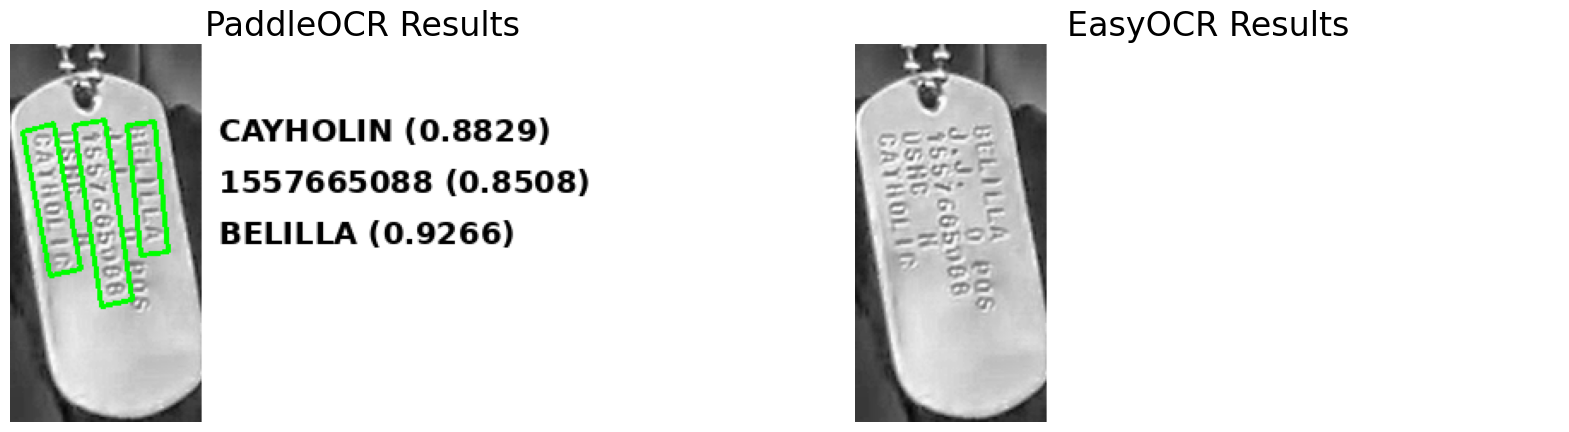


PaddleOCR Results:
  CAYHOLIN (confidence=0.8829)
  1557665088 (confidence=0.8508)
  BELILLA (confidence=0.9266)

EasyOCR Results:


In [ ]:
main(IMG_PATH3, FONT_PATH)

## Edge Detection (Canny)

### 1. Load the image

In [ ]:
img_color = cv2.imread(IMG_PATH2)
if img_color is None:
    raise FileNotFoundError("Could not load the image. Check your path.")

### 2. Convert to Grayscale

In [ ]:
gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

### 3. Enhance contrast with CLAHE

In [ ]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
gray_clahe = clahe.apply(gray)

### 4. Gaussian Blur to reduce noise

In [ ]:
blurred = cv2.GaussianBlur(gray_clahe, (3, 3), 0)

### 5. Canny Edge Detection
####    - Lower threshold decides how many weaker edges to include.
####    - Upper threshold decides strong edges.
####    - Adjust these based on your image.

In [ ]:
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

### **Visualize Results**

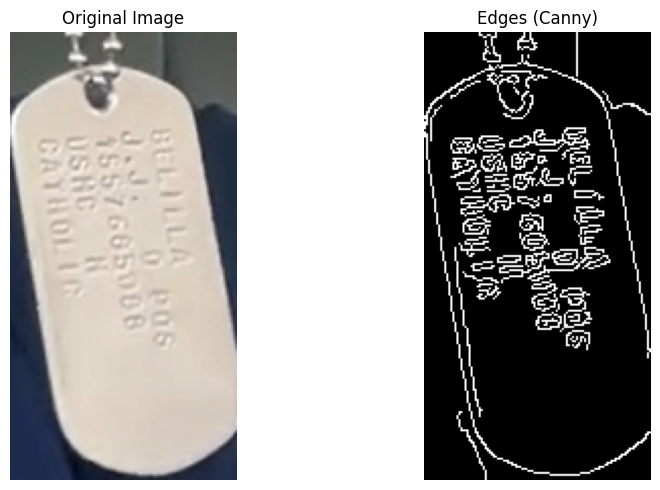

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("Edges (Canny)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
cv2.imwrite("Edges.png", edges)

True

Running PaddleOCR...
[2025/02/13 19:11:53] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

Running EasyOCR...


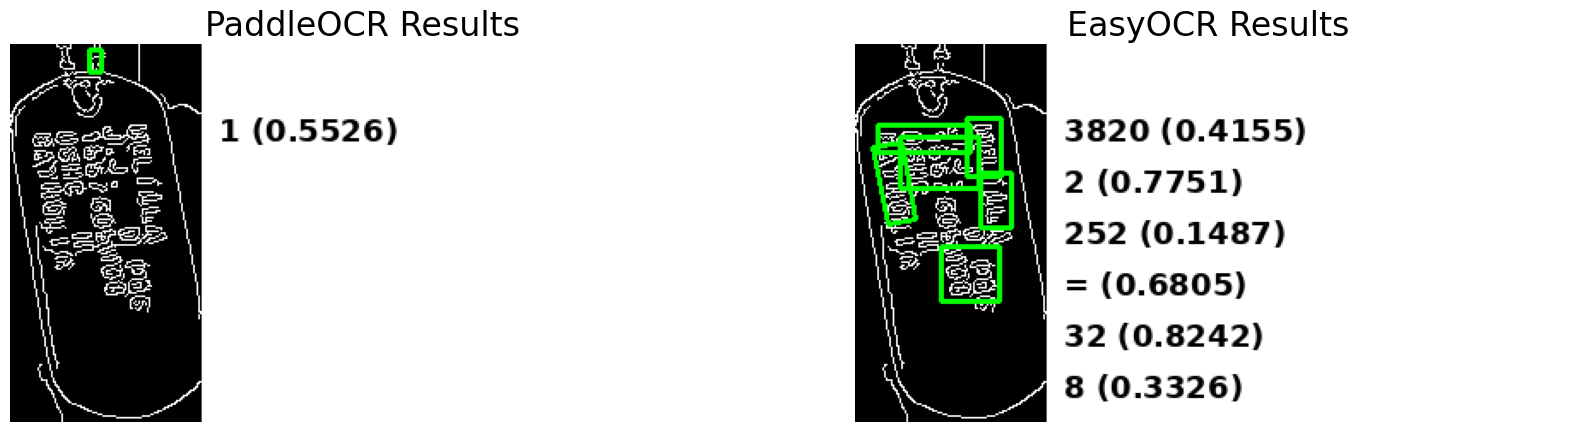


PaddleOCR Results:
  1 (confidence=0.5526)

EasyOCR Results:
  3820 (confidence=0.4155)
  2 (confidence=0.7751)
  252 (confidence=0.1487)
  = (confidence=0.6805)
  32 (confidence=0.8242)
  8 (confidence=0.3326)


In [ ]:
main("/content/Edges.png", FONT_PATH)